# CITS5508 Lab 5: Comparing Performance of MLP and CNN on CIFAR-10 Classification Task

Name: Joey Koh<br>
Student number: 21506379  
Date created: 6 May 2020  
Last modified: 20 May 2020  

This notebook compares the performance of a Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN) on classifying images in the CIFAR-10 dataset.<br>

Data: 32x32 pixel images, 60k total images.<br>

10 Classes (mutually exclusive): airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck <br>

Training set: 50k images split in random order into 5 training batches (10k images each). 5k images per class overall. Some batches may contain more images from one class than another.<br>

Test set: 1k randomly selected images from each class. 10k total.

Data structure:<br>
Each training/test batch file contains a dictionary with following elements.
- data: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
- labels: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In "batches.meta", a python dictionary object with following entries:
- label_names : a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.
<br>

A MLP and a CNN are trained and judged in performance.

Database Citation:
Krizhevsky, A. and Hinton, G., 2009. Learning multiple layers of features from tiny images.

**Note:**
- Due to the random nature of some algorithms, the results referred to (e.g. accuracy) may vary slightly.
- For hyperparameter tuning, custom functions were made instead of GridSearch for better insight and practice in the tuning process.
- You can verify experiments and learning curves by changing the run_mlp/cnn_experiments to True.
- This notebook was run cell-by-cell on GoogleColab, but the cell numbers do not seem to save properly when I download the file. (some cells say [0] when they actually were run between the numbered ones properly in order). You can verify this by changing the run_mlp/cnn_experiments to True and/or simply running it.

## 1. Setup, Data Preparation
Import libraries to be used and bring the data in.<br>

In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
from tensorflow import keras

#file tools
import os
import pickle

#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.lines as mlines
#import seaborn as sns; sns.set(color_codes=True)
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_squared_error
import warnings;
warnings.filterwarnings("ignore") #clear warnings

In [0]:
#To run the experimental code, set to True
run_mlp_experiments = False
run_cnn_experiments = False

In [3]:
# IMPOTRTANT: set the path where the data files are relative to the Notebook file. 
# You can change the variable pathname below to anything that suits you, For example,
# if your Notebook file is to be run on Google Colab, then you will need to set up
# this variable properly, e.g., 
#       pathname = os.path.join('My Drive', 'CITS5508').

#For Google Colab
"""
from google.colab import drive
drive.mount('/content/gdrive') #already mounted, but need to remount if changing runtime
#print(os.listdir('.'))
pathname = 'gdrive/My Drive/CITS5508'
#os.listdir('gdrive/My Drive/CITS5508') #lists directory
"""



# Before submitting your Notebook file to cssubmit, ensure that you change
# this variable back to '.'
pathname = '.'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#prepare a log directory for tensorboard visualisations if used
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir(): #get path based on root log directory and time
  import time
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") #time string
  return os.path.join(root_logdir, run_id) #concat log dir path with time string id

run_logdir = get_run_logdir()

In [0]:
# function for loading the data_batch_file
def load_pickle_file(filename, path='.'):
    '''
    This function reads the given pickle file and returns a dictionary object.
    '''
    with open(os.path.join(path,filename), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict  


def load_training(filename_prefix, N_batches, path='.'):
    '''
    This function reads the 5 data batches and returns the X_train and y_train numpy arrays.
    To save memory space, X_train is set to 'float32' (single precision floating point number).
    If this causes an issue, it can be set to 'float64'. y_train is set to uint8. This is
    the same data type as the MNIST dataset, so it should be fine.
    '''
    batch_no = range(1,N_batches+1)  # the batch numbers start at 1
    # Read in the data_batch_ files
    batches = [load_pickle_file(filename_prefix+str(b), path=path) for b in batch_no]

    # variable batches is a list containing 5 elements, each of which is a dictionary object

    # compose our X_train and y_train
    # according to the download site, the training set should have 50,000 instances. We caldulate
    # the length from the dictionary that we read in anyway.
    batch_sizes = [len(batches[i][b'labels']) for i in range(N_batches)]
    train_set_size = np.sum(batch_sizes)

    X_train = np.zeros((train_set_size, width, height, Nchannels), dtype='float32')
    y_train = np.zeros(train_set_size).astype('uint8')
    loc = 0
    for i in range(N_batches):
        X_train[loc:(loc+batch_sizes[i]),:,:,:] = np.rollaxis( #for data structure orientation
            np.reshape(batches[i][b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0 #normalise pixel values to range 0..1
        y_train[loc:(loc+batch_sizes[i])] = batches[i][b'labels']
        loc += batch_sizes[i]
    return X_train, y_train


def load_testing(filename, path='.'):
    '''
    This function reads the test_batch and returns X_test and y_test.
    To save memory space, X_test is set to 'float32' (single precision floating point number).
    If this causes an issue, it can be set to 'float64'. y_test is set to uint8. This is
    the same data type as the MNIST dataset, so it should be fine.
    '''
    # now read test_batch and construct the test set
    test_dict = load_pickle_file(filename, path=path)
    
    X_test = np.rollaxis(np.reshape(test_dict[b'data'], (-1,Nchannels,height,width)), 1, 4) / 255.0
    #X_test = np.swapaxes(np.swapaxes(
    #    np.reshape(test_dict[b'data'], (-1,Nchannels,width,height)), 1, 3), 1, 2) / 255.0 #normalise pixel values to range 0..1
    X_test = X_test.astype('float32')
    y_test = np.array(test_dict[b'labels'], dtype='uint8')
    return X_test, y_test

In [6]:
# According to the download site, the training set is split into five batches stored in 5 files,
# each colour image has dimension equal to 32 x 32 x 3, and there are 10 classes.
width, height, Nchannels = 32, 32, 3 #3 for RGB values per pixel
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

N_batches = 5  
train_filename_prefix = 'data_batch_'
test_filename = 'test_batch'
#Load data sets
train_X, train_y = load_training(train_filename_prefix, N_batches, path=pathname)
test_X, test_y = load_testing(test_filename, path=pathname)
#Quick check that all data is loaded
print('Number of training instances:', train_X.shape[0])
print('Number of test instances:    ', test_X.shape[0])

Number of training instances: 50000
Number of test instances:     10000


## 2. Multilayer Perceptron (MLP)
We design a fully connected MLP with two hidden layers and 10 epochs. We tune some hyperparameters by first comparing 8 variations of the model with different settings to select the optimal settings.

### 2.1 Setting Experiments

#### Hyperparameter Tuning Process
We consider 3 hyperparameters with 2 suitable settings each. From this, we obtain 8 variations of the MLP model. We train these on a subset of training data with a validation set split by ratio. Then, we observe the learning curves of our experiments to look out for overfitting particularly, and determine which model produces the best validation accuracy.

The 3 hyperparameters tuned are:
- **Connection Weight Initialisation (CWI)**: We initialise the connection weights to deal with the vanishing/exploding gradient problem. This occurs mainly due to variance of layer outputs being significantly greater than the variance of its inputs, and the saturation of the logistic sigmoid activation function producing a negligible derivative during large magnitude inputs. The resulting gradients decrease/increase drastically as the algorithm reaches lower layers and we have a poor or slow convergence to a good solution.

> We require the signal to not die out or explode and saturate. The signal must flow properaly in both directions – forward for predictions and backwards for backpropogation. Ideally, the layer's input/output variances must be equal, and the variance of gradients must be equal before/after passing through a layer. By initializing the connection weights randomly, it helps prevent vanishing/exploding gradients.

> As different weight initialization strategies suit different activation functions better, we explore two different initialization strategies and the activation functions they are usually used with.

> 1. CWI1: Normal He initialization with ReLU activation function. 
  >> He initialization with a normal distribution has a variance of ```2/fan in``` with a mean of 0. It is suited for ReLU functions and its variants. The ReLU (rectified linear unit) activation function is optimised for speed and also does not saturate for positive values.

 >2. CWI2: Normal LeCun initilization with SELU activation function.
  >> LeCun initilization with a normal distribution has a variance of ```1/fan avg``` with a mean of 0. It is suited for the SELU activation function. The Scaled ReLU (SELU) activation function has a self-normalising property which allows it to better preserve the variance and mean of layer outputs during training.

>> (fan in being number of layer input units, and fan avg being the average of input/output layer units)<br>

- **Learning Rate Scheduling (LRS)**: High learning rates cause divergence while low learning rates make the convergence to a good solution take a long time. Learning rate scheduling generally takes advantage of having a relatively high initial learning rate to converge faster, and slowing it down once the progress drops to prevent divergence. With the limited epochs for this model, learning rate scheduling allows us to reduce training time and also converge to a better solution than a constant learning rate would.

  1. LRS1: Performance Scheduling.
  > This method measures the validation error every N steps, before reducing the learning rate by a factor when error fails to reduce. I.e. we reduce learning rate when performance of training at current learning rate yields less in reducing error.
  2. LRS2: Power Scheduling.
  > Based on iteration step number, we set a decay rate in the below equation. Thus, every set number of steps the initial learning rate decays.
  ```lr = lr0 / (1 + steps / s)**c```<br>
  Keras uses `c=1` and `s = 1 / decay`

- **Early Stopping**: This regularisation technique helps **prevent overfitting** on the training data. We aim to stop training once the validation error reaches a minimum. However, given the small number of epochs allowed and from experimenting, it was found that early stopping is less viable in improving the model as we tend to observe improvements on validation accuracy even in the last few epochs. We monitor the val_loss as we are trying to prevent overfitting on training set, thus we are based on improvement towards validation set. For early stopping, we explore different settings for minimum improvement in val_loss required to continue training and the patience in number of epochs before halting.<br>

  1. ES1: no min_delta and patience of 3 to force early stopping.
  2. ES2: min_delta improvement of 0.02 and patience of 2 to force early stopping.

**From these, we produce 8 variations to train and compare performance on a validation set**<br>


In [0]:
#Set common parameters
#For layers
width, height, Nchannels = 32, 32, 3 #32x32 pixels per image, with 3 for RGB values per pixel
neurons_hidden_1, neurons_hidden_2, neurons_output = 100, 100, 10 #number of neurons
val_ratio = 0.1 #for validation set split

#For Connection Weight initialisation
cwi1_activation_hidden, cwi2_activation_hidden = "relu", "selu" #activation function in hidden layers
cwi1_weight_init, cwi2_weight_init = "he_normal", "lecun_normal" #strategy to randomly initilize connection weights at each layer

#For Learning Rate scheduling
lrs1_cb = keras.callbacks.ReduceLROnPlateau(factor= 0.5, monitor= 'val_loss', patience= 2, min_delta= 0.01) #performance scheduling
lr_mlp = 0.01 #constant to ensure learning rate is set everytime function is called
lrs1_optimizer = keras.optimizers.SGD(lr= lr_mlp)
lrs2_optimizer = keras.optimizers.SGD(lr= lr_mlp, decay= 1e-4) #power scheduling

#For Early Stopping
es1_cb = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 3, restore_best_weights= True)
es2_cb = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 2, min_delta= 0.05, restore_best_weights= True)

#Function for training MLP model variations
def mlp_train_model(model_name, cwi_activation, cwi_weight_init, lrs_optimizer, es_cb, lrs_cb = None, tensorboard_cb = None):
  print("\nTraining: ", model_name)
  model_mlp = keras.models.Sequential([
                                  keras.layers.Flatten(input_shape=[width,height,Nchannels]), #input layer 
                                  keras.layers.Dense(neurons_hidden_1, activation= cwi_activation, kernel_initializer= cwi_weight_init), #hidden layer 1
                                  keras.layers.Dense(neurons_hidden_2, activation= cwi_activation, kernel_initializer= cwi_weight_init), #hidden layer 2
                                  keras.layers.Dense(neurons_output, activation = "softmax") #output layer
  ])
  #Compile and train model
  model_mlp.compile(loss= "sparse_categorical_crossentropy", optimizer= lrs_optimizer, metrics=["accuracy"])
  if lrs_cb == None:
    hist = model_mlp.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [es_cb])
  else:
    hist = model_mlp.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [lrs_cb, es_cb])

  #Reset optimizers for next use, to ensure learning rate is reset
  lrs1_optimizer = keras.optimizers.SGD(lr= lr_mlp)
  lrs2_optimizer = keras.optimizers.SGD(lr= lr_mlp, decay= 1e-4) #power scheduling
  return hist, model_mlp, lrs1_optimizer, lrs2_optimizer #return the History object and model trained


#### Optimiser, Loss Function, Validation Set
- Optimiser: SGD (Stochastic Gradient Descent) Optimiser was used. While other optimisers might be faster to converge and/or adaptive. We are not tuning the optimiser used, and adaptive learning rate algorithms would interfere/diminish the impact of the learning rate scheduling settings explored.
- Loss function: sparse_catgeorical_crossentropy loss function used as this is a multi-class classification problem with integers representing each category (not 1-hot encoded)
- Validation Set: instead of passing a validation set directly to the fitting, we choose a ratio (val_ratio) to randomly form a validation set every epoch. In this way, the model gets exposed to a wider range of training data than a fixed validation set would have caused.


In [0]:
if run_mlp_experiments == True:
  #Call training function for each model to get history objects and trained models
  history_mlp_1, model_mlp_1, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_1", cwi1_activation_hidden, cwi1_weight_init, lrs1_optimizer, es1_cb, lrs_cb = lrs1_cb)
  history_mlp_2, model_mlp_2, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_2", cwi2_activation_hidden, cwi2_weight_init, lrs1_optimizer, es1_cb, lrs_cb = lrs1_cb)
  history_mlp_3, model_mlp_3, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_3", cwi1_activation_hidden, cwi1_weight_init, lrs2_optimizer, es1_cb)
  history_mlp_4, model_mlp_4, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_4", cwi2_activation_hidden, cwi2_weight_init, lrs2_optimizer, es1_cb)
  history_mlp_5, model_mlp_5, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_5", cwi1_activation_hidden, cwi1_weight_init, lrs1_optimizer, es2_cb, lrs_cb = lrs1_cb)
  history_mlp_6, model_mlp_6, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_6", cwi2_activation_hidden, cwi2_weight_init, lrs1_optimizer, es2_cb, lrs_cb = lrs1_cb)
  history_mlp_7, model_mlp_7, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_7", cwi1_activation_hidden, cwi1_weight_init, lrs2_optimizer, es2_cb)
  history_mlp_8, model_mlp_8, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_8", cwi2_activation_hidden, cwi2_weight_init, lrs2_optimizer, es2_cb)

In [0]:
fig_size = (6,4)
def learning_curves(hist, numb, default= fig_size): #learning curve plot function
  print("\nLearning curve",numb)
  pd.DataFrame(hist.history).plot(figsize= fig_size)
  plt.grid(True)
  plt.show()

if run_mlp_experiments == True:  #Plot learning curves
  print('Learning curves for 8 MLP model experiments')
  learning_curves(history_mlp_1,"1")
  learning_curves(history_mlp_2,"2")
  learning_curves(history_mlp_3,"3")
  learning_curves(history_mlp_4,"4")
  learning_curves(history_mlp_5,"5")
  learning_curves(history_mlp_6,"6")
  learning_curves(history_mlp_7,"7")
  learning_curves(history_mlp_8,"8")

In [0]:
if run_mlp_experiments == True: #print validation accuracies
  print("model_mlp_1 validation accuracy = ", round(history_mlp_1.history['val_accuracy'][-1],3))
  print("model_mlp_2 validation accuracy = ", round(history_mlp_2.history['val_accuracy'][-1],3))
  print("model_mlp_3 validation accuracy = ", round(history_mlp_3.history['val_accuracy'][-1],3))
  print("model_mlp_4 validation accuracy = ", round(history_mlp_4.history['val_accuracy'][-1],3))
  print("model_mlp_5 validation accuracy = ", round(history_mlp_5.history['val_accuracy'][-1],3))
  print("model_mlp_6 validation accuracy = ", round(history_mlp_6.history['val_accuracy'][-1],3))
  print("model_mlp_7 validation accuracy = ", round(history_mlp_7.history['val_accuracy'][-1],3))
  print("model_mlp_8 validation accuracy = ", round(history_mlp_8.history['val_accuracy'][-1],3))

#### Experiment Findings
MLP Model number:
1. CW1, LRS1, ES1
2. CW2, LRS1, ES1
3. CW1, LRS2, ES1
4. CW2, LRS2, ES1
5. CW1, LRS1, ES2
6. CW2, LRS1, ES2
7. CW1, LRS2, ES2
8. CW2, LRS2, ES2
```
model_mlp_1 validation accuracy =  0.483
model_mlp_2 validation accuracy =  0.426
model_mlp_3 validation accuracy =  0.463
model_mlp_4 validation accuracy =  0.452
model_mlp_5 validation accuracy =  0.412
model_mlp_6 validation accuracy =  0.384
model_mlp_7 validation accuracy =  0.372
model_mlp_8 validation accuracy =  0.231
```
**Validation Accuracies Conclusions**:<br>
From these output final validation accuracies of the 8 MLP variations, we observe that model_mlp_1 produces the highest accuracy of 0.483<br>
Thus, **model 1 has the optimum hyperparameter settings** from our experiments.

- Connection Weight Initialisation (CWI): 
  1. CWI1: Normal He initialization with ReLU activation function. 
  2. CWI2: Normal LeCun initilization with SELU activation function.
> The LeCun initialisation with normal distribution and SELU activation function performed better than the He init with ReLU activation. Although, ReLU function has high compatibility with the SGD optimiser used, the self-normalising property of SELU likely contributed to a better model trained.

- Learning Rate Scheduling (LRS): 
  1. LRS1: Performance Scheduling.
  2. LRS2: Power Scheduling.
> Performance scheduling worked better than Power scheduling. Basing learning rate schedule on the the validation loss decrease was consistent decay was better more effective than a defined decay based on steps.

- Early Stopping:
  1. ES1: no min_delta and patience of 3 to force early stopping with greater leniency. 
  2. ES2: min_delta improvement of 0.02 and patience of 2 to force early stopping.
> Having no early stopping from ES1 was better than forcing an early stopping with ES2 consistently. This is due to the model not converging to a good solution in ES2's early stopping within 10 epochs (which is already a low number of epochs).

**Learning Curve Observations:**
- Overfitting seems to begin when the validation loss starts increasing every epoch, while the training loss continues to decrease. In some cases, this is seen even in early epochs (e.g. 4, 5). However, it is unlikely that the model can overfit so early on, as we often observe that this pattern is temporary for a few epochs. We notice that the validation loss returns to decreasing every epoch shortly after.
- From the forced 'early stopping' with the 10 epoch limit, we observe the learning curve trend of improving accuracies still. It reinforces the fact that the model requires more epochs to converge to a good solution better.

### 2.2 Optimal Settings
Using optimal parameters from experiments<br>
The highest accuracy on the validation set was achieved with model 1, which is CW1, LRS1, ES1

In [11]:
#Training MLP optimal model
history_mlp, model_mlp, lrs1_optimizer, lrs2_optimizer = mlp_train_model("model_mlp_1", cwi1_activation_hidden, cwi1_weight_init, lrs1_optimizer, es1_cb, lrs_cb = lrs1_cb)


Training:  model_mlp_1
Epoch 1/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.9045 - accuracy: 0.3154 - val_loss: 2.0133 - val_accuracy: 0.2716 - lr: 0.0100
Epoch 2/10
1407/1407 [==============================] - 4s 3ms/step - loss: 1.7317 - accuracy: 0.3820 - val_loss: 2.1047 - val_accuracy: 0.2712 - lr: 0.0100
Epoch 3/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6556 - accuracy: 0.4107 - val_loss: 1.9510 - val_accuracy: 0.3040 - lr: 0.0100
Epoch 4/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.6067 - accuracy: 0.4268 - val_loss: 1.6936 - val_accuracy: 0.4044 - lr: 0.0100
Epoch 5/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5688 - accuracy: 0.4427 - val_loss: 1.7209 - val_accuracy: 0.3860 - lr: 0.0100
Epoch 6/10
1407/1407 [==============================] - 3s 2ms/step - loss: 1.5354 - accuracy: 0.4554 - val_loss: 1.7708 - val_accuracy: 0.3834 - lr: 0.0100
Epoch 7/10
1407/1407 [============

In [12]:
#Inspect model architecture 
model_mlp.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


#### MLP Network Architecture
Feedforward neural network which uses backpropagation for training.<br>
**Layer Settings**
- Input layer: Each input image consists of 32x32 pixels with each pixel represented by 3 RGB values. As the first input layer disregards the pixels' positions, we need to flatten the image into a 1D vector to obtain the number of input neurons required and to feed it in.
> The input layer flattens the image, giving an output of 32x32x3 = 3072

- 2 Hidden layers: Same no. of neurons used for both layers to reduce no. of parameters to tune. Similar performance to pyramid shape configuration.
> First dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 3072(inputs) x100(layer neurons) +100 (for bias neurons) = 307300. The number of outputs equals the number of layer neurons of 100.<br>
> Second dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 100(inputs) x100(layer neurons) +100 (for bias neurons) = 10100. The number of outputs also is 100.

- Output layer: 10 neurons for the 10 possible classes. Softmax activation function used as this is a multiclass problem with mutually exclusive classes. This ensures outputs are probabilities that sum to 1.
> Output dense layer: With 10 output neurons for the 10 classes the number of parameters is 100(inputs) x10(layer neurons) +10 (for bias neurons) = 1010.<br>

Observe:
- The number of parameters reduce each layer. This is good as we want the network to narrow in some form as we get closer to classification in the final output layer.

#### 2.2.1 Confusion Matrix and Accuracy

In [0]:
from matplotlib.ticker import MultipleLocator #for force labelling plot ticks

#Function to generate confusion matrix
def conf_matrix(actual_y, pred_y, model):
    #confusion matrix generation
    class_pred_y = np.array(class_names)[pred_y] #get predicted class names
    class_actual_y = np.array(class_names)[actual_y]

    conf_mx = confusion_matrix(class_actual_y, class_pred_y, class_names)
    print("This is the confusion matrix for",model,"\n",conf_mx)

    #visualisation setup
    alpha = class_names
    conf_data = conf_mx

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_data, interpolation='nearest')
    fig.colorbar(cax) #adds colour bar to figure
    #axis settings
    ax.xaxis.set_major_locator(MultipleLocator(1)) #force label every cell
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels(['']+alpha) #add tick labels from alpha (classnames)
    ax.set_yticklabels(['']+alpha)
    plt.setp(ax.get_xticklabels(), rotation=90) #orient x-axis labels

    plt.show
    print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")

This is the confusion matrix for MLP 
 [[621  27  45  19  12  23  36  17 129  71]
 [ 61 544  11  16   7  34  18  19  63 227]
 [129  30 303  73  63 100 212  33  27  30]
 [ 56  26  73 261  25 247 186  28  27  71]
 [ 94  14 159  41 245  87 264  53  25  18]
 [ 51  24  77 156  34 402 145  48  28  35]
 [ 16  19  53  74  52  55 678  11  14  28]
 [ 79  29  59  63  65 110  77 423  14  81]
 [144  64  11  23  11  31  15   7 616  78]
 [ 67 145   8  25   8  22  33  29  61 602]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


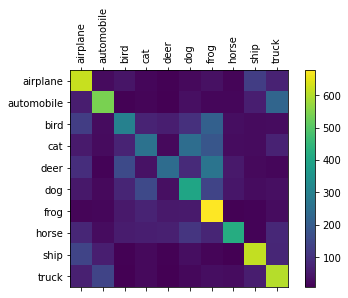

In [14]:
test_y_mlp_pred = np.argmax(model_mlp.predict(test_X), axis=-1) #get predicted class index numbers
#call confusion matrix function
conf_matrix(test_y, test_y_mlp_pred, "MLP")


Learning curve Final MLP


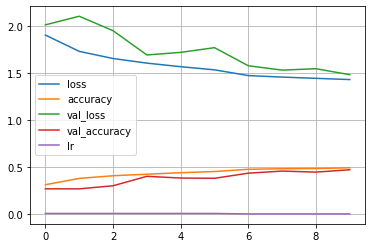

Evaluating MLP model on test set
313/313 [==============================] - 1s 2ms/step - loss: 1.4779 - accuracy: 0.4695


[1.4778512716293335, 0.46950000524520874]

In [15]:
#plot learning curve
learning_curves(history_mlp, "Final MLP")
#Evaluate model accuracy on test set
print("Evaluating MLP model on test set")
model_mlp.evaluate(test_X,test_y) #occurs in batches

### Classification Results of tuned MLP model

**Accuracy score on test set:** The tuned MLP model obtained a 0.4781 accuracy on the test set classification task. Considering a random guess would be 0.1, this result is better than nothing. <br>

**Confusion matrix observations:** 
- Generally, we have values concentrated on the diagonal. Indicating correct predictions.
- However, we notice some visible non-dark squares outside the diagonal. These incorrect predictions have some noticable patterns in that their images have similar features (eyes, shape, object structure, wheels...etc).
- For vehicles: the following incorrect predictions are common (actual, predicted): (airplane, ship), (truck, automobile), (automobile, truck). Perhaps it is due to airplanes/ships having similar streamlined outlines and colour, truck/automobiles being wheeled vehicles and having similar windows format.
- For animals: bird, cat, deer, dog, frog, horse have many dim squares outside the diagonal indicating incorrect predictions. It is likely due to the common features of legs, eyes, colour, outline. In particular, the cats are often incorrectly classified as dogs. <br>

**Learning Curve Observations:**
- Training and validation accuracies steadily increasing during training.
- Training and validation loss generally decreasing during training.
- Validation curves close to training curves, hence not much overfitting is occurring.
- Variation in validation loss likely due to random selection of validation set every epoch.
- Initially model seems to be generalising better on validation set than training set. Not the case, as validation error is computed at epoch's end while training error is computed with a running mean during each epoch. I.e. training curve should be shifted half an epoch left. Which would result in similar overlap at training beginning. 

**Explanation:**
The somewhat unimpressive performance in accuracy is due a few reasons.
- **Constrictions in network architecture** with a limit of 2 hidden layers. MLPs can theoretically model complex problems with a single layer given enough neurons. However, for complex problems like image classification here, deep networks with more layers have a higher parameter efficiency than shallow ones. MLPs are fully connected and aim to model low-level structures in lower hidden layers, continuously building up to higher-level structures in higher layers. When we only have two layers instead of say 5, we have reduced parameter efficiency and lack intermediate layers for intermediate-level structure modelling. We essentially are forced to jump ahead.
- **Low number of epochs**, 10. By restricting the number of passes through the training set, we essentially are implementing early stopping on epoch number 10 regardless of improvement to accuracy or loss function. A better practice is to simply implement early stopping instead and not limit the number of epochs. We observe that the model still has accuracy improvements in the 10th epoch, by stopping the training there, the accuracy cannot improve further even if the model has not converged to a good solution.<br>

**Hyperparameters tuned** This model had the optimum settings found through experiments. However, exploring more hyperparameter settings would likely yield a more optimised model. For example, trying out more adaptive activation functions or increasing the number of neurons in a layer.


#### 2.2.2 Correct and Wrong Predictions

The first 20 correctly classified images of the test set


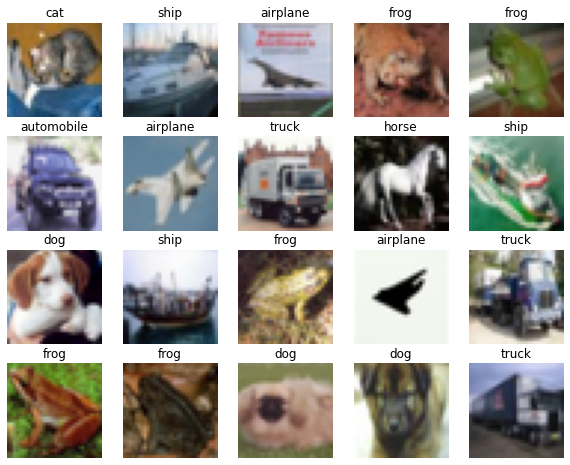

The first 20 incorrectly classified images of the test set. 
 Titles are actual class, predicted class respectively


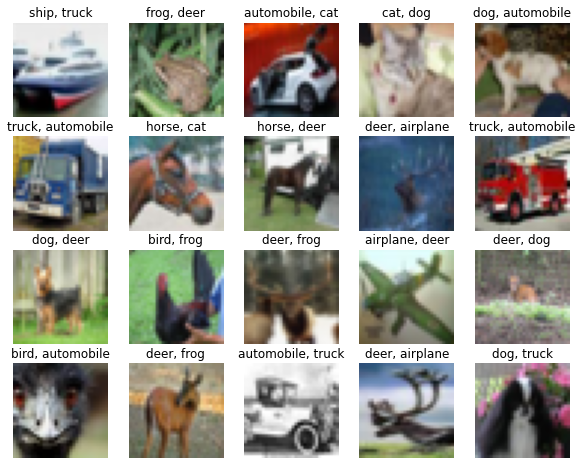

In [16]:
# display 20 correct predictions in the test set
print('The first 20 correctly classified images of the test set')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] == test_y_mlp_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

# display 20 incorrect predictions in the test set
print('The first 20 incorrectly classified images of the test set. \n Titles are actual class, predicted class respectively')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] != test_y_mlp_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]] +", "+ class_names[test_y_mlp_pred[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

**Observations**:
- For correctly classified images, we notice that the model is good at classifying dogs and ships well, this aligns with our confusion matrix's bright diagonal squares.
- For incorrectly classified images, we notice that the model fails to generalise as well when the images are more open to interpretation. For example the dogs could look like deers, the airplane in the blue sky looks like a ship surrounded by blue water...etc. This aligns with our conclusions from our confusion matrix.

## 3. Convolutional Neural Network (CNN)
We design a sparsely connected CNN with two convolutional layers, a pooling layer and a fully connected network at the end. With a limit of 10 epochs. We tune some hyperparameters by first comparing 16 variations of the model with different settings to select the optimal settings.

### 3.1 Setting Experiments

#### Hyperparameter Tuning Process
We consider 4 hyperparameters with 2 suitable settings each. From this, we obtain 16 variations of the CNN model. We train these on a subset of training data with a validation set split by ratio. Then, we observe the learning curves of our experiments to look out for overfitting particularly, and also determine which model produces the best validation accuracy.

- **Kernel Size (KS)**: The size of convolution filter/kernel used. Indicates the size of receptive fields imposed. This defines the maximum field size on the image that is recognised (after training) by each feature map in that convolutional layer.
  1. ks1: 5x5 then a 3x3, both with stride of 1 as the image is not very large. We try to reduce the spatial dimension of the image without losing much information in the first layer, followed by a 3x3 in second layer that uses less parameters.
  2. ks2: 3x3 then another 3x3 both with stride of 1. We try to use fewer parameters in computations throughout.

- **Number of Filters/Kernels (NOF)**: Each convolutional layer is really made up of several feature maps. Each map is made from a filter. A Convolutional Layey simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs. We explore how doubling the number of filters would change performance.
  1. nof1: 64
  2. nof2: 128

- **Dropout Rate (DR)**: This regularisation technique simply drops some neurons temporarily during each training step. We explore whether dropping out more or less is better in this case.
  1. dr1: 0.1
  2. dr2: 0.3

- **Activation Function (AF)**: We explore two different activation functions. SELU for self-normalisation and ReLU for optimised computation time. We also tie the connection weight initialisation hyperparameter into this experiment.

 1. af1: Normal He initialization with ReLU activation function.
 > He initialization with a normal distribution has a variance of ```2/fan in``` with a mean of 0. It is suited for ReLU functions and its variants. The ReLU (rectified linear unit) activation function is optimised for speed and also does not saturate for positive values.

 2. af2: Normal LeCun initilization with SELU activation function.
> LeCun initilization with a normal distribution has a variance of ```1/fan avg``` with a mean of 0. It is suited for the SELU activation function. The Scaled ReLU (SELU) activation function has a self-normalising property which allows it to better preserve the variance and mean of layer outputs during training.

> (fan in being number of layer input units, and fan avg being the average of input/output layer units)<br>

- **Connection Weight Initialisation (CWI)**: We initialise the connection weights to deal with the vanishing/exploding gradient problem. This occurs mainly due to variance of layer outputs being significantly greater than the variance of its inputs, and the saturation of the logistic sigmoid activation function producing a negligible derivative during large magnitude inputs. The resulting gradients decrease/increase drastically as the algorithm reaches lower layers and we have a poor or slow convergence to a good solution.

> We require the signal to not die out or explode and saturate. The signal must flow properaly in both directions – forward for predictions and backwards for backpropogation. Ideally, the layer's input/output variances must be equal, and the variance of gradients must be equal before/after passing through a layer. By initializing the connection weights randomly, it helps prevent vanishing/exploding gradients.

> As different weight initialization strategies suit different activation functions better, we explore two different initialization strategies and the activation functions they are usually used with.

Other hyperparameters set:
- **Padding:** "VALID" is used as for these images, the feature importance of boundary pixels are negligible. Thus, we can simply ignore them with no padding and speed up computation time as well.

**From these, we produce 16 variations to train and compare performance on a validation set**<br>
CNN Model number:
1. ks1, nof1, dr1, af1
2. ks1, nof1, dr1, af2
3. ks1, nof1, dr2, af1
4. ks1, nof1, dr2, af2
5. ks1, nof2, dr1, af1
6. ks1, nof2, dr1, af2
7. ks1, nof2, dr2, af1
8. ks1, nof2, dr2, af2
9. ks2, nof1, dr1, af1
10. ks2, nof1, dr1, af2
11. ks2, nof1, dr2, af1
12. ks2, nof1, dr2, af2
13. ks2, nof2, dr1, af1
14. ks2, nof2, dr1, af2
15. ks2, nof2, dr2, af1
16. ks2, nof2, dr2, af2

In [0]:
  #Set common parameters
##For layers
width, height, Nchannels = 32, 32, 3 #32x32 pixels per image, with 3 for RGB values per pixel
neurons_hidden_1, neurons_hidden_2, neurons_output = 100, 100, 10 #number of neurons
val_ratio = 0.1 #for validation set split

#For convolutional layers
padding = "VALID"
pooling_size = 2

#For Kernel Size
ks1, ks2 = (5,3,1), (3,3,1) #last value is stride

#For Number of Filters
nof1, nof2 = 64, 128

#For Dropout rate
dr1, dr2 = 0.1, 0.3

#For Activation Function, tuples of activation function and connection weight initialisation strategy
af1, af2 = ("relu","he_normal"),("selu","lecun_normal")

#For Learning Rate scheduling and optimiser
lrs1_cb = keras.callbacks.ReduceLROnPlateau(factor= 0.5, monitor= 'val_loss', patience= 2, min_delta= 0.1) #performance scheduling
lr_cnn = 0.01 #constant to ensure learning rate is set everytime function is called
cnn_optimizer= keras.optimizers.SGD(lr= lr_cnn)

#Function for training CNN model variations
def cnn_train_model(model_name, kernel_size, numb_filters, drop_rate, activation_and_weight_init, cnn_optimizer, es_cb= None, lrs_cb = None):
    print("\nTraining: ", model_name)
    model_cnn = keras.models.Sequential([
                                        keras.layers.Conv2D(filters= numb_filters, kernel_size= kernel_size[0], strides= kernel_size[2], padding= padding, activation= activation_and_weight_init[0], input_shape= (width, height, Nchannels)), #convolution layer
                                        keras.layers.Conv2D(filters= numb_filters, kernel_size= kernel_size[1], strides= kernel_size[2], padding= padding, activation= activation_and_weight_init[0]), #convolution layer
                                        keras.layers.MaxPooling2D(pooling_size), #pooling layer
                                        keras.layers.Flatten(), #Flatten for fully connected network input
                                        keras.layers.Dropout(drop_rate),
                                        keras.layers.Dense(neurons_hidden_1, activation= activation_and_weight_init[0], kernel_initializer= activation_and_weight_init[1]), #hidden layer 1
                                        keras.layers.Dropout(drop_rate),
                                        keras.layers.Dense(neurons_hidden_2, activation= activation_and_weight_init[0], kernel_initializer= activation_and_weight_init[1]), #hidden layer 2
                                        keras.layers.Dropout(drop_rate),
                                        keras.layers.Dense(neurons_output, activation = "softmax") #output layer     
    ])
    #Compile and train model
    model_cnn.compile(loss= "sparse_categorical_crossentropy", optimizer= cnn_optimizer, metrics=["accuracy"])
    if lrs_cb == None:
      hist = model_cnn.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [])
    else:
      hist = model_cnn.fit(train_X, train_y, epochs= 10, validation_split = val_ratio, callbacks= [lrs_cb])
    #Reset optimizers for next use, to ensure learning rate is reset
    cnn_optimizer= keras.optimizers.SGD(lr= lr_cnn)
    return hist, model_cnn, cnn_optimizer #return the History object and model trained



#### Optimiser, Loss Function, Validation Set
Similar optimiser and loss function to MLP used for similar reasons. Also for better comparison on the model rather than optimiser used.
- Optimiser: SGD (Stochastic Gradient Descent) Optimiser was used. While other optimisers might be faster to converge and/or adaptive. We are not tuning the optimiser used, and adaptive learning rate algorithms would interfere/diminish the impact of the learning rate scheduling settings explored.
- Loss function: sparse_catgeorical_crossentropy loss function used as this is a multi-class classification problem with integers representing each category (not 1-hot encoded)
- Validation Set: instead of passing a validation set directly to the fitting, we choose a ratio (val_ratio) to randomly form a validation set every epoch. In this way, the model gets exposed to a wider range of training data than a fixed validation set would have caused.


In [0]:
if run_cnn_experiments == True:
  #Call training function for each model to get history objects and trained models
  history_cnn_1, model_cnn_1, cnn_optimizer = cnn_train_model("model_cnn_1", ks1, nof1, dr1, af1, cnn_optimizer)
  history_cnn_2, model_cnn_2, cnn_optimizer = cnn_train_model("model_cnn_2", ks1, nof1, dr1, af2, cnn_optimizer)#
  history_cnn_3, model_cnn_3, cnn_optimizer = cnn_train_model("model_cnn_3", ks1, nof1, dr2, af1, cnn_optimizer)
  history_cnn_4, model_cnn_4, cnn_optimizer = cnn_train_model("model_cnn_4", ks1, nof1, dr2, af2, cnn_optimizer)
  history_cnn_5, model_cnn_5, cnn_optimizer = cnn_train_model("model_cnn_5", ks1, nof2, dr1, af1, cnn_optimizer)
  history_cnn_6, model_cnn_6, cnn_optimizer = cnn_train_model("model_cnn_6", ks1, nof2, dr1, af2, cnn_optimizer)#
  history_cnn_7, model_cnn_7, cnn_optimizer = cnn_train_model("model_cnn_7", ks1, nof2, dr2, af1, cnn_optimizer)
  history_cnn_8, model_cnn_8, cnn_optimizer = cnn_train_model("model_cnn_8", ks1, nof2, dr2, af2, cnn_optimizer)#
  history_cnn_9, model_cnn_9, cnn_optimizer = cnn_train_model("model_cnn_9", ks2, nof1, dr1, af1, cnn_optimizer)
  history_cnn_10, model_cnn_10, cnn_optimizer = cnn_train_model("model_cnn_10", ks2, nof1, dr1, af2, cnn_optimizer)#
  history_cnn_11, model_cnn_11, cnn_optimizer = cnn_train_model("model_cnn_11", ks2, nof1, dr2, af1, cnn_optimizer)
  history_cnn_12, model_cnn_12, cnn_optimizer = cnn_train_model("model_cnn_12", ks2, nof1, dr2, af2, cnn_optimizer)
  history_cnn_13, model_cnn_13, cnn_optimizer = cnn_train_model("model_cnn_13", ks2, nof2, dr1, af1, cnn_optimizer)
  history_cnn_14, model_cnn_14, cnn_optimizer = cnn_train_model("model_cnn_14", ks2, nof2, dr1, af2, cnn_optimizer)##
  history_cnn_15, model_cnn_15, cnn_optimizer = cnn_train_model("model_cnn_15", ks2, nof2, dr2, af1, cnn_optimizer)
  history_cnn_16, model_cnn_16, cnn_optimizer = cnn_train_model("model_cnn_16", ks2, nof2, dr2, af2, cnn_optimizer)

In [0]:
fig_size = (6,4)
if run_cnn_experiments == True: #Plot learning curves
  print('Learning curves for 16 CNN model experiments')
  learning_curves(history_cnn_1,"1")
  learning_curves(history_cnn_2,"2")
  learning_curves(history_cnn_3,"3")
  learning_curves(history_cnn_4,"4")
  learning_curves(history_cnn_5,"5")
  learning_curves(history_cnn_6,"6")
  learning_curves(history_cnn_7,"7")
  learning_curves(history_cnn_8,"8")
  learning_curves(history_cnn_9,"9")
  learning_curves(history_cnn_10,"10")
  learning_curves(history_cnn_11,"11")
  learning_curves(history_cnn_12,"12")
  learning_curves(history_cnn_13,"13")
  learning_curves(history_cnn_14,"14")
  learning_curves(history_cnn_15,"15")
  learning_curves(history_cnn_16,"16")


In [0]:
if run_cnn_experiments == True: #print validation accuracies of experiments
  print("model_cnn_1 validation accuracy = ", round(history_cnn_1.history['val_accuracy'][-1],3))
  print("model_cnn_2 validation accuracy = ", round(history_cnn_2.history['val_accuracy'][-1],3))
  print("model_cnn_3 validation accuracy = ", round(history_cnn_3.history['val_accuracy'][-1],3))
  print("model_cnn_4 validation accuracy = ", round(history_cnn_4.history['val_accuracy'][-1],3))
  print("model_cnn_5 validation accuracy = ", round(history_cnn_5.history['val_accuracy'][-1],3))
  print("model_cnn_6 validation accuracy = ", round(history_cnn_6.history['val_accuracy'][-1],3))
  print("model_cnn_7 validation accuracy = ", round(history_cnn_7.history['val_accuracy'][-1],3))
  print("model_cnn_8 validation accuracy = ", round(history_cnn_8.history['val_accuracy'][-1],3))
  print("model_cnn_9 validation accuracy = ", round(history_cnn_9.history['val_accuracy'][-1],3))
  print("model_cnn_10 validation accuracy = ", round(history_cnn_10.history['val_accuracy'][-1],3))
  print("model_cnn_11 validation accuracy = ", round(history_cnn_11.history['val_accuracy'][-1],3))
  print("model_cnn_12 validation accuracy = ", round(history_cnn_12.history['val_accuracy'][-1],3))
  print("model_cnn_13 validation accuracy = ", round(history_cnn_13.history['val_accuracy'][-1],3))
  print("model_cnn_14 validation accuracy = ", round(history_cnn_14.history['val_accuracy'][-1],3))
  print("model_cnn_15 validation accuracy = ", round(history_cnn_15.history['val_accuracy'][-1],3))
  print("model_cnn_16 validation accuracy = ", round(history_cnn_16.history['val_accuracy'][-1],3))

#### Experiment Findings
CNN Model number:
1. ks1, nof1, dr1, af1
2. ks1, nof1, dr1, af2
3. ks1, nof1, dr2, af1
4. ks1, nof1, dr2, af2
5. ks1, nof2, dr1, af1
6. ks1, nof2, dr1, af2
7. ks1, nof2, dr2, af1
8. ks1, nof2, dr2, af2
9. ks2, nof1, dr1, af1
10. ks2, nof1, dr1, af2
11. ks2, nof1, dr2, af1
12. ks2, nof1, dr2, af2
13. ks2, nof2, dr1, af1
14. ks2, nof2, dr1, af2
15. ks2, nof2, dr2, af1
16. ks2, nof2, dr2, af2
```
model_cnn_1 validation accuracy =  0.656
model_cnn_2 validation accuracy =  0.642
model_cnn_3 validation accuracy =  0.606
model_cnn_4 validation accuracy =  0.635
model_cnn_5 validation accuracy =  0.65
model_cnn_6 validation accuracy =  0.663
model_cnn_7 validation accuracy =  0.576
model_cnn_8 validation accuracy =  0.633
model_cnn_9 validation accuracy =  0.631
model_cnn_10 validation accuracy =  0.593
model_cnn_11 validation accuracy =  0.651
model_cnn_12 validation accuracy =  0.646
model_cnn_13 validation accuracy =  0.676
model_cnn_14 validation accuracy =  0.63
model_cnn_15 validation accuracy =  0.654
model_cnn_16 validation accuracy =  0.633
```
**Validation Accuracies Conclusion:**<br>
From these output final validation accuracies of the 16 CNN variations, we observe that model_cnn_13 produces the highest accuracy of 0.676.<br>
Thus, **model 13 has the optimum hyperparameter settings** from our experiments.

- **Kernel Size (KS)**: The size of convolution filter/kernel used. Indicates the size of receptive fields imposed.
  1. ks1: 5x5 with stride of 2, then a 3x3 with stride of 1. We try to reduce the spatial dimension of the image without losing much information in the first layer, followed by a 3x3 in second layer that uses less parameters.
  2. ks2: 3x3 then another 3x3 both with stride of 1. We try to use fewer parameters in computations throughout.
> Both options were comparable. But ks2 seemed to perform better sometimes. It is likely that the small image size meant that restricting the spatial dimensions initially (in ks1) would be more damaging to the signal than expected.

- **Number of Filters/Kernels (NOF)**: Each convolutional layer is really made up of several feature maps. Each map is made from a filter. A Convolutional Layey simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs. We explore how doubling the number of filters would change performance.
  1. nof1: 64
  2. nof2: 128
> Using more filters (nof2) performed better. Makes sense as we have more feature maps per convolutional layer – hence, more features can be mapped which allows better recognition of patterns.

- **Dropout Rate (DR)**: This regularisation technique simply drops some neurons temporarily during each training step. We explore whether dropping out more or less is better in this case.
  1. dr1: 0.1
  2. dr2: 0.3
> Having a lower dropout rate was better in this data. Meaning that less neurons were ignored and could contribute in training. In other words, dr2 was regularising the model too much.

13. ks2, nof2, dr1, af1

- **Activation Function (AF)**: We explore two different activation functions. SELU for self-normalisation and ReLU for optimised computation time. We also tie the connection weight initialisation hyperparameter into this experiment.

 1. af1: Normal He initialization with ReLU activation function. 
 2. af2: Normal LeCun initilization with SELU activation function.
> af1 and af2 had similar performances. However, af1 seemed slightly better when the model used ks2; while af2 seemed slightly better when the model used ks1. The self-normalising property of SELU led to better learning sometimes, similar to MLP experiments. However, it seemed that model_cnn_13 use of He init with the fast optimised ReLU worked well with ks2 and lead to overall best performance.

**Learning Curve Observations:**
- Overfitting seems to begin when the validation loss starts increasing every epoch, while the training loss continues to decrease. In some variations, this is seen as spikes of validation loss increase with training loss steady decrease. This is likely due to the randomness from splitting the validation set randomly every epoch. Which exposes a different variety of images every epoch.
- Initially the model seems to be generalising better on validation set than training set. Not the case, as validation error is computed at epoch's end while training error is computed with a running mean during each epoch. I.e. training curve should be shifted half an epoch left. Which would result in similar overlap at training beginning. 


### 3.2 Optimal Settings
Using optimal parameters from experiments<br>

In [21]:
#Ask user if model retraining is required
retrain = input('Retrain the CNN model? (y/n)')
if retrain == 'y':
  #Train optimum CNN model
  history_cnn, model_cnn, cnn_optimizer = cnn_train_model("model_cnn_13", ks2, nof2, dr1, af1, cnn_optimizer)
  model_cnn.save("Joey_Koh_CNN_model.h5", overwrite= False) #HDF5 format
else:
  #To restore from file
  model_cnn = keras.models.load_model("Joey_Koh_CNN_model.h5")

#Inspect model
model_cnn.summary() 



Retrain the CNN model? (y/n)y

Training:  model_cnn_13
Epoch 1/10
1407/1407 [==============================] - 15s 11ms/step - loss: 1.9285 - accuracy: 0.3044 - val_loss: 1.6984 - val_accuracy: 0.3942
Epoch 2/10
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5656 - accuracy: 0.4349 - val_loss: 1.5592 - val_accuracy: 0.4366
Epoch 3/10
1407/1407 [==============================] - 15s 10ms/step - loss: 1.3843 - accuracy: 0.4993 - val_loss: 1.2947 - val_accuracy: 0.5428
Epoch 4/10
1407/1407 [==============================] - 15s 10ms/step - loss: 1.2622 - accuracy: 0.5468 - val_loss: 1.2472 - val_accuracy: 0.5560
Epoch 5/10
1407/1407 [==============================] - 15s 10ms/step - loss: 1.1533 - accuracy: 0.5892 - val_loss: 1.0895 - val_accuracy: 0.6150
Epoch 6/10
1407/1407 [==============================] - 15s 10ms/step - loss: 1.0653 - accuracy: 0.6225 - val_loss: 1.1416 - val_accuracy: 0.5994
Epoch 7/10
1407/1407 [==============================] - 15s 11ms/step

#### CNN Network Architecture
**Layer Settings**
- **Rules for Convolutional Layers**: 
> - Output width or height = (Input_width_or_height - kernel_length + 2*padding_size)/stride_size + 1
> - No. of params = output_channels * (input_channels * kernel_size + 1)
- Input Convolutional layer: Each input image consists of 32x32 pixels with each pixel represented by 3 RGB channels. The first convolutional layer consists of 128 filters which produces 128 feature maps. As no padding is applied, the 3x3 kernel size causes the last 2 pixels in both image dimensions to be dropped. Hence, we get 30x30 with 128 feature maps output. With stride = 1, it does not change the output size.
> - Output width or height = (32 - 3 + 2*0)/1 + 1 = 30
> - no. of params = 128 * (3* (3x3) + 1) = 3584

- Second Convolutional layer: With 30x30 input with 128 channels. The second convolutional layer consists of 128 filters which produces 128 feature maps. From equations below, we get 28x28 with 128 feature maps output. With stride = 1, it does not change the output size.
> - Output width or height = (30 - 3 + 2*0)/1 + 1 = 28
> - no. of params = 128 * (128* (3x3) + 1) = 147584

- Pooling Layer: Subsamples the input to reduce computational load, no. of parameters and memory usage. With pooling size = 2, we transform the 28x28x128 input into a 14x14x128 output.

- Flatten Layer: Flattens the multi-dimensional input into a single vector as we are done with convolutional layers. Now we input into the fully connected network. (14*14*128 input = 25088 output)

- Dropout Layers: Randomly ignores a portion of neurons during training specified by the dropout rate. Helps to regularise the model.

- 2 Hidden layers: Same no. of neurons used for both layers to reduce no. of parameters to tune. Similar performance to pyramid shape configuration.
> First dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 25088(inputs) x100(layer neurons) +100 (for bias neurons) = 2508900. The number of outputs equals the number of layer neurons of 100.<br>
> Second dense hidden layer: It consists of 100 fully connected neurons, so the number of parameters is 100(inputs) x100(layer neurons) +100 (for bias neurons) = 10100. The number of outputs also is 100.

- Output layer: 10 neurons for the 10 possible classes. Softmax activation function used as this is a multiclass problem with mutually exclusive classes. This ensures outputs are probabilities that sum to 1.
> Output dense layer: With 10 output neurons for the 10 classes the number of parameters is 100(inputs) x10(layer neurons) +10 (for bias neurons) = 1010.<br>

Observe:
- In the Convolutional layers segment, the number of channels increase each layer. This is good as we want the information to be captured in the channels rather than the image dimensions. We thus narrow the image size as we get towards the fully connected segment.
- In the fully connected segment, the number of parameters reduce each layer. This is good as we want the network to narrow in some form as we get closer to classification in the final output layer.

#### 3.2.1 Confusion Matrix and Accuracy

This is the confusion matrix for CNN 
 [[801  41  35  15   4   7  13   7  39  38]
 [ 19 857  14   6   0   9   3   4  14  74]
 [106  12 606  49  14 105  59  35   7   7]
 [ 31  28 119 435  10 243  65  41   8  20]
 [ 63  12 205  80 247 125 146 111   7   4]
 [ 23  11  82 151   8 637  23  56   4   5]
 [ 12  21  75  72   3  42 760   8   2   5]
 [ 19   8  60  34  17 106   6 735   1  14]
 [145  83  20  16   2  13   6   4 664  47]
 [ 54 168  14  11   1  12   5  22   9 704]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


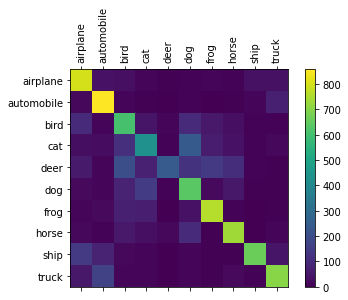

In [22]:
test_y_cnn_pred = np.argmax(model_cnn.predict(test_X), axis=-1) #get predicted class index numbers
#call confusion matrix function
conf_matrix(test_y, test_y_cnn_pred, "CNN")


Learning curve CNN final


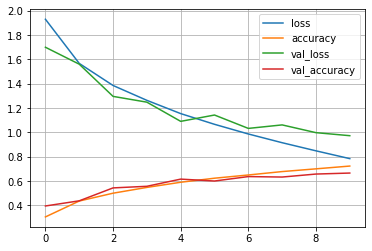

Evaluating CNN model on test set
313/313 [==============================] - 1s 5ms/step - loss: 1.0100 - accuracy: 0.6446


[1.0100035667419434, 0.644599974155426]

In [23]:
#plot learning curve
learning_curves(history_cnn, "CNN final")
#Evaluate model accuracy on test set
print("Evaluating CNN model on test set")
model_cnn.evaluate(test_X,test_y) #occurs in batches

### Classification Results of tuned CNN model

**Accuracy score on test set:** The tuned CNN model obtained a 0.6737 accuracy on the test set classification task. Considering a random guess would be 0.1, this result is better than nothing. <br>

**Confusion matrix observations:** 
- Generally, we have values concentrated on the diagonal. Indicating correct predictions.
- However, we notice some visible non-dark squares outside the diagonal. These incorrect predictions have some noticable patterns in that their images have similar features (eyes, shape, object structure, wheels...etc).
- For vehicles: the following incorrect predictions are somewhat common (actual, predicted): (truck, automobile), (ship, airplane). Perhaps it is due to airplanes/ships having similar streamlined outlines and colour, truck/automobiles being wheeled vehicles. Thus, similar patterns were observe for multiple classes.
- For animals: the following incorrect predictions are common (actual, predicted): (dog, cat), (horse, deer). It is likely due to the common features of legs, eyes, colour, outline. In particular, the dogs are often incorrectly classified as cats. While horses and deers have similar build. <br>

**Learning Curve Observations:**
- Training and validation accuracies steadily increasing during training.
- Training and validation loss generally decreasing during training.
- Validation curves close to training curves, hence not much overfitting is occurring.
- Small spikes in validation loss likely due to random selection of validation set every epoch.
- Initially model seems to be generalising better on validation set than training set. Not the case, as validation error is computed at epoch's end while training error is computed with a running mean during each epoch. I.e. training curve should be shifted half an epoch left. Which would result in similar overlap at training beginning. <br>

**Explanation:**
The decent performance in test accuracy is due a few reasons.
- **Complexity in network architecture**, we essentially have few convolutional layers great at recognising multiple features with multiple filters per layer. With a fully connected MLP at the end to use all channel outputs for classification. In addition to pooling layers and dropout to aid the network during training. This degree of complexity helps in image classification, a complex task as well.

- **Convolutional Layer Suitability and Hierarchical structure**: As neurons in convolutional layers are connected only to small rectangular fields from its inputs, the network can concentrate on small-low level features and assemble them into larger higher-level features in the next layer and onwards. This makes CNNs (due to using convolutional layers and also pooling layers), particularly well suited to image classification.

However, convergence to a good solution is impacted by: 
- **Low number of epochs**, 10. By restricting the number of passes through the training set, we essentially are implementing early stopping on epoch number 10 regardless of improvement to accuracy or loss function. A better practice is to simply implement early stopping instead and not limit the number of epochs. We observe that the model still has accuracy improvements in the 10th epoch, by stopping the training there, the accuracy cannot improve further even if the model has not converged to a good solution.<br>

Regarding:<br>
**Hyperparameters tuned:** This model had the optimum settings found through experiments. However, exploring more hyperparameter settings would likely yield a more optimised model that might train efficiently even with more epochs. For example, implementing early stopping and learning rate scheduling.


#### 3.2.2 Correct and Wrong Predictions

The first 20 correctly classified images of the test set


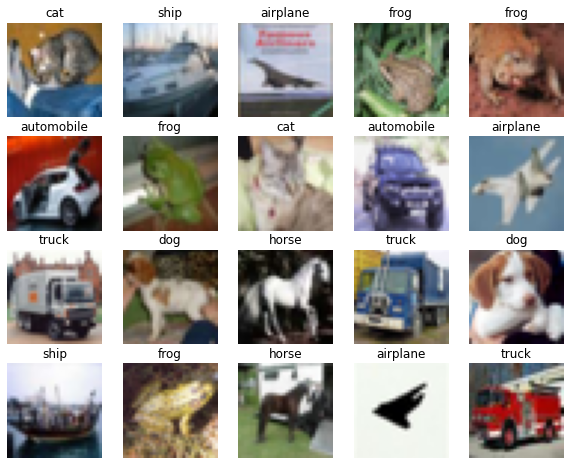

The first 20 incorrectly classified images of the test set. 
 Titles are actual class, predicted class respectively


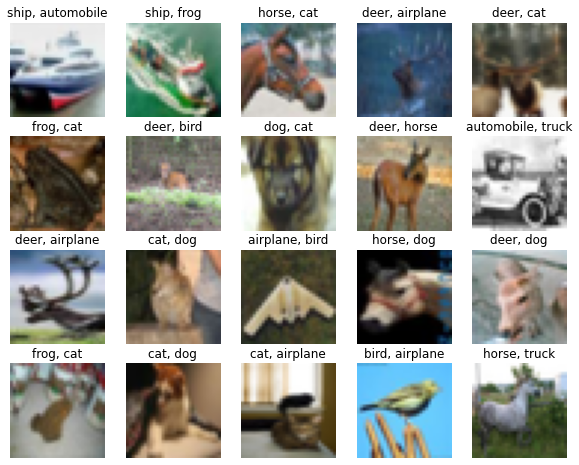

In [24]:
# display 20 correct predictions in the test set
print('The first 20 correctly classified images of the test set')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] == test_y_cnn_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

# display 20 incorrect predictions in the test set
print('The first 20 incorrectly classified images of the test set. \n Titles are actual class, predicted class respectively')
plt.figure(figsize=(10, 8))
i, n = 0, 0
while i < 20:
  if test_y[n] != test_y_cnn_pred[n]:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(test_X[n])
    plt.axis('off')
    ax.set_title(class_names[test_y[n]] +", "+ class_names[test_y_cnn_pred[n]])
    i = i +1
    n = n +1 
  else:
    n = n +1

plt.show()

**Observations**:
- For correctly classified images, we notice that the model is good at classifying generally all classes well, this aligns with our confusion matrix's strong diagonal.
- For incorrectly classified images, we notice that the model fails to generalise as well when the images are more open to interpretation. For example the cats looks like dogs, and sometimes the birds looks like a frog...etc. This aligns with our conclusions from our confusion matrix.

##4. Comparison of MLP and CNN Models

###Confusion Matrices

This is the confusion matrix for MLP 
 [[621  27  45  19  12  23  36  17 129  71]
 [ 61 544  11  16   7  34  18  19  63 227]
 [129  30 303  73  63 100 212  33  27  30]
 [ 56  26  73 261  25 247 186  28  27  71]
 [ 94  14 159  41 245  87 264  53  25  18]
 [ 51  24  77 156  34 402 145  48  28  35]
 [ 16  19  53  74  52  55 678  11  14  28]
 [ 79  29  59  63  65 110  77 423  14  81]
 [144  64  11  23  11  31  15   7 616  78]
 [ 67 145   8  25   8  22  33  29  61 602]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis



This is the confusion matrix for CNN 
 [[801  41  35  15   4   7  13   7  39  38]
 [ 19 857  14   6   0   9   3   4  14  74]
 [106  12 606  49  14 105  59  35   7   7]
 [ 31  28 119 435  10 243  65  41   8  20]
 [ 63  12 205  80 247 125 146 111   7   4]
 [ 23  11  82 151   8 637  23  56   4   5]
 [ 12  21  75  72   3  42 760   8   2   5]
 [ 19   8  60  34  17 106   6 735   1  14]
 [145  83  20  16   2  13   6   4 664  47]
 [ 54

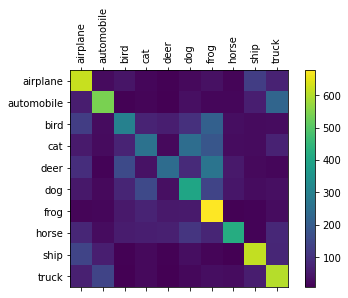

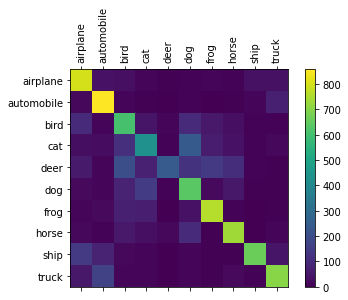

In [25]:
#call confusion matrix function
conf_matrix(test_y, test_y_mlp_pred, "MLP")
print("\n\n")
conf_matrix(test_y, test_y_cnn_pred, "CNN")

**Comparison, MLP top matrix and CNN bottom matrix**:
- The CNN matrix has a brighter diagonal (more correct predictions) than the MLP matrix.
- The MLP matrix has more scattering of dim squares (incorrect predictions) that dilute from the main diagonal (correct predictions) compared to the CNN matrix.
- In common misclassifications, for example: trucks incorrectly classified as automobiles. The CNN matrix (value count) generally makes fewer mistakes than the MLP matrix, being only marginally worse if otherwise.

### Classification Accuracies

In [26]:
#Evaluate model accuracy on test set
print("Evaluating MLP model on test set")
model_mlp.evaluate(test_X,test_y) #occurs in batches
print("\nEvaluating CNN model on test set")
model_cnn.evaluate(test_X,test_y) #occurs in batches


Evaluating MLP model on test set
313/313 [==============================] - 1s 2ms/step - loss: 1.4779 - accuracy: 0.4695

Evaluating CNN model on test set
313/313 [==============================] - 1s 5ms/step - loss: 1.0100 - accuracy: 0.6446


[1.0100035667419434, 0.644599974155426]

-  On the test set classification task, the **MLP had an accuracy of 0.4781** while the **CNN had an accuracy of 0.6737**.
- In other words, the CNN was 40.9% better in classification accuracy compared to the MLP. This is significant.
- Given that the training set size is not very big for image classification, often needing millions – we might not have enough data to train the both networks given its complexity. This was the best achieved with limited data.

### Network Architecture

In [27]:
print("MLP Summary \n")
model_mlp.summary() 
print("\nCNN Summary \n")
model_cnn.summary() 

MLP Summary 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________

CNN Summary 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      

**From confusion matrix and test set classification accuracy observations, the CNN model outperforms the MLP model. This is largely due to a different network architecture.** For further detail, visit the relevant previous Network Architecture segments.<br>
MLP:
- 1 input flatten layer, 2 hidden dense layers, 1 output softmax layer.
- Fully connected layers causes the number of parameters to be high. This is inefficient due to redundancy in such high dimensions.
- Unlike CNN, disregards spatial information from flattening input image into vectors. This damages the signal, as image pixels gain relevancy from relative positioning to each other.

CNN:
- Sparsely connected network reduces number of parameters which improves efficiency. Weights are smaller and shared being less wasteful than MLP.
- Accounts for spatial information and patterns by panning filters in convolutional layers around the entire image. This allows patterns to be found throughout.
- The fully connected feedforward network at the end of the sparsely connected convolutional network, is essentially an MLP. In a way, the CNN also is partially a MLP, so the training from a deeper and more complex architecture results from the contributions of both a CNN and an MLP.
- New Building blocks: 
> - Convolutional Layer: Simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs. As all neurons in a feature map share the same parameters, the no. of parameters needed are drastically reduced. Once a CNN has learned to recognise a pattern in one location, it is able to recognise a pattern in any location. In contrast, once a regular MLP has learned to recognise a pattern in one location, it can only recognise in that particular location.
> - Pooling layer: Subsampling the input and aggregation, helps to reduce risk of overfitting to the training data. Leading to better generalisation on unseen data.

Number of Training parameters: The MLP model used 318,410 while the CNN model used 2,671,178. The reason that the CNN uses more is due to its more complex architecture than the MLP. With more training parameters, the CNN takes longer overally to train. However, the overall training times in the next section explains a bit further in the time efficiency as well.




### Training Time

- From training the optimum model, generally the MLP took around **5s per epoch** and **3 to 4ms per step**. While the CNN generally took **22s per epoch** and **16ms per step**. 
- As both optimised models used 10 epochs to train the model, it seems that the CNN model takes longer than the MLP model. However, this is not exactly true. The CNN actually takes a shorter amount of time to reach the validation accuracy of the MLP. From observing the training of both optimum models: the MLP achieved a validation accuracy of approximately **0.47 after 10 epochs with around 50seconds** of training. While the CNN model reached a validation accuracy of approximately **0.47 only after 2 epochs with total 45seconds** of training time. 
- Convolution is an expensive process, which also leads to more time required to train.
- This efficiency in training time for CNN is attributed to the network architecture of CNNs. And the suitability of convolutional layers in learning to recognising patterns with fewer parameters than MLP models.